In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import data

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# Reading data and first 5 rows
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Summary statistics of data, sum of missing values and the dimensions of the dataframe (rows,columns).

print('Describe: \n{}'.format(df.describe()))
print('Nulls: \n{}'.format(df.isnull().sum()))
print('Shape: \n{}'.format(df.shape))

Describe: 
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+

In [4]:
# Number of Fraud and Non-fraud examples from dataframe
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
# Columns Name
print(df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [6]:
# Number of examples and percent of total transactions that are fraudulent
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} \n'.format(
    total, pos))

print("Percent of total transactions that are fraudulent")
print(df["Class"].mean()*100)

Examples:
    Total: 284807
    Positive: 492 

Percent of total transactions that are fraudulent
0.1727485630620034


In [7]:
# Losses due to fraud and mean amount
print("Losses due to fraud:")
fraud_amounts = df[df.Class == 1].Amount
total_fraud_loss = fraud_amounts.sum()
mean_fraud_loss = fraud_amounts.mean()

print(f"Total amount lost to fraud: {total_fraud_loss}")
print(f"Mean amount per fraudulent transaction: {mean_fraud_loss}")

print("Compared to normal transactions:")
normal_amounts = df[df.Class == 0].Amount
total_normal_amount = normal_amounts.sum()
mean_normal_amount = normal_amounts.mean()

print(f"Total amount from normal transactions: {total_normal_amount}")
print(f"Mean amount per normal transaction: {mean_normal_amount}")

Losses due to fraud:
Total amount lost to fraud: 60127.97
Mean amount per fraudulent transaction: 122.21132113821139
Compared to normal transactions:
Total amount from normal transactions: 25102462.04
Mean amount per normal transaction: 88.29102242231328


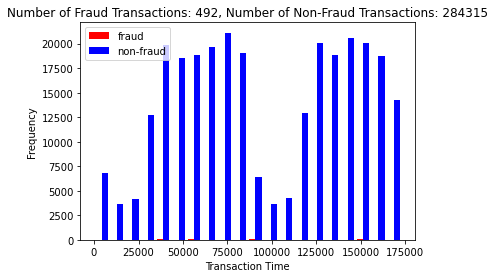

In [8]:
fraud = df['Class'] == 1
not_fraud = df['Class'] == 0

# Select the time values of fraud and non-fraud transactions
fraud_time = df.Time[fraud]
non_fraud_time = df.Time[not_fraud]

# Find the number of fraud and non-fraud transactions
num_fraud = len(fraud_time)
num_not_fraud = len(non_fraud_time)

# Create a histogram plot for fraud and non-fraud transactions
plt.hist([fraud_time, non_fraud_time], bins = 20, color = ['r', 'b'], label = ['fraud', 'non-fraud'])
plt.xlabel('Transaction Time')
plt.ylabel('Frequency')
plt.legend()
plt.title("Number of Fraud Transactions: {}, Number of Non-Fraud Transactions: {}".format(num_fraud, num_not_fraud))
plt.show()

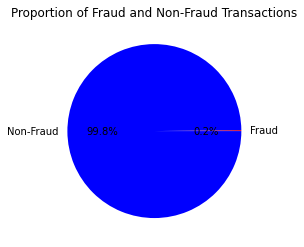

In [9]:
# Create a pie chart
labels = ['Fraud', 'Non-Fraud']
sizes = [num_fraud, num_not_fraud]
colors = ['r', 'b']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Proportion of Fraud and Non-Fraud Transactions")
plt.show()

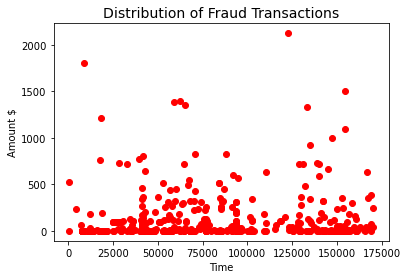

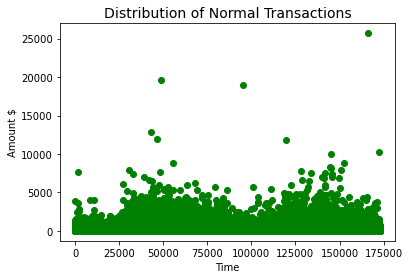

In [10]:
# Distribution of Fraud and Non-Fraud Transactions
plt.scatter(df.Time[df.Class == 1], df.Amount[df.Class == 1], color='red')
plt.title('Distribution of Fraud Transactions', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Amount $')
plt.show()

plt.scatter(df.Time[df.Class == 0], df.Amount[df.Class == 0], color='green')
plt.title('Distribution of Normal Transactions', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Amount $')
plt.show()

In [11]:
# Creating new dataframe
cleaned_df = df.copy()

# Deleting Time Column
cleaned_df.pop('Time')

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [12]:
cleaned_df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [13]:
non_fraud = cleaned_df[cleaned_df['Class']==0]
fraud = cleaned_df[cleaned_df['Class']==1]

In [14]:
non_fraud.shape, fraud.shape

((284315, 30), (492, 30))

In [15]:
non_fraud = non_fraud.sample(fraud.shape[0])
non_fraud.shape

(492, 30)

In [16]:
data = fraud.append(non_fraud, ignore_index=True)
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,-2.151462,-0.771962,2.199804,-2.379259,0.096819,-0.070204,0.199209,-1.555517,3.150258,0.012265,...,0.523454,0.373974,-0.453642,0.056811,0.284482,-0.137699,-1.176253,-0.192971,32.00,0
980,-0.574536,0.096195,-0.356205,-0.282093,0.739521,-1.280711,1.891300,-0.896548,0.479282,-0.571448,...,0.050894,0.931652,0.249697,-0.051494,0.058146,-0.221819,-0.309597,-0.497828,132.89,0
981,2.272594,-1.535335,-0.693490,-1.625756,-1.516127,-0.451512,-1.457541,0.028303,-1.053188,1.770232,...,-0.134616,0.064194,0.232887,-0.395267,-0.316243,-0.170182,0.014795,-0.062341,7.00,0
982,-0.492144,-0.067665,0.490772,-0.780750,-0.004039,1.777260,0.818601,0.465264,0.408462,-0.820924,...,-0.053012,0.004436,0.486938,-1.493962,-0.870523,-0.636553,0.116457,-0.033364,200.58,0


In [17]:
data['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

In [18]:
# Create X by selecting all columns except 'Class' from the data DataFrame
X = df.drop('Class', axis=1)

# Create y by selecting the 'Class' column from the data DataFrame
y = cleaned_df['Class']


In [19]:
X = data.drop('Class', axis = 1)
y = data['Class']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [21]:
X_train.shape, X_test.shape

((787, 29), (197, 29))

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [24]:
X_train.shape

(787, 29)

In [25]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [26]:
X_train.shape, X_test.shape

((787, 29, 1), (197, 29, 1))

In [40]:
epochs = 50
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape = X_train[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 28, 32)            96        
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 32)            128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 64)            4160      
_________________________________________________________________
batch_normalization_3 (Batch (None, 27, 64)            256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 27, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1728)             

In [42]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics='accuracy')

In [43]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
25/25 [==============================] - 2s 20ms/step - loss: 0.9181 - accuracy: 0.6366 - val_loss: 0.6024 - val_accuracy: 0.8274
Epoch 2/50
25/25 [==============================] - 0s 9ms/step - loss: 0.4115 - accuracy: 0.8297 - val_loss: 0.5739 - val_accuracy: 0.7208
Epoch 3/50
25/25 [==============================] - 0s 17ms/step - loss: 0.3877 - accuracy: 0.8564 - val_loss: 0.5556 - val_accuracy: 0.6904
Epoch 4/50
25/25 [==============================] - 1s 29ms/step - loss: 0.3005 - accuracy: 0.8945 - val_loss: 0.5363 - val_accuracy: 0.6904
Epoch 5/50
25/25 [==============================] - 0s 9ms/step - loss: 0.2987 - accuracy: 0.9022 - val_loss: 0.5110 - val_accuracy: 0.7005
Epoch 6/50
25/25 [==============================] - 0s 9ms/step - loss: 0.2768 - accuracy: 0.9060 - val_loss: 0.4805 - val_accuracy: 0.7208
Epoch 7/50
25/25 [==============================] - 0s 9ms/step - loss: 0.2597 - accuracy: 0.9072 - val_loss: 0.4477 - val_accuracy: 0.7868
Epoch 8/50
25/25 

In [45]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

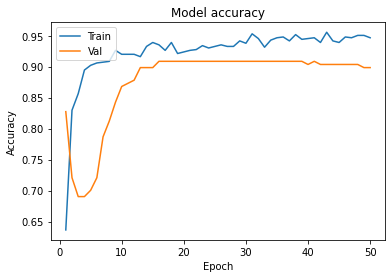

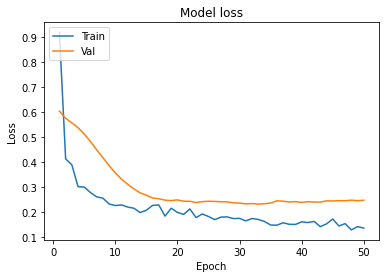

In [46]:
plot_learningCurve(history, epochs)